## Fitting Henyey and Greenstein (H-G) phase function using Mixture Density Networks (MDN) ##

Dependencies:
- Python 3.8
- Pytorch 1.8.1

## Introduction of H-G function##
J. Patrick Harrington, [HG note](https://www.astro.umd.edu/~jph/HG_note.pdf)

Henyey and Greenstein (1941) introduced a function which, by the variation of one parameter, $−1 \le g \le 1$, ranges from backscattering through isotropic scattering to forward scattering. H-G function is defined as:
\begin{equation}
    p(\theta) = \frac{1}{4\pi} \frac{1-g^2}{[1+g^2-2g\cos(\theta)]^{3/2}}. 
\end{equation}    

It can be written as a function of $\mu=\cos(\theta)$:
\begin{equation}
    p(\mu)=\frac{1}{2} \frac{1-g^2}{[1+g^2-2g\mu]^{3/2}}.
\end{equation}

In order to use the H-G function for Monte Carlo models, we need the accumulated distribution:
\begin{equation}
    P(\mu)=\frac{1}{2} \int_{-1}^{\mu}{\frac{1-g^2}{[1+g^2-2g\mu]^{3/2}} d\mu}.
\end{equation}

The integral has the value
\begin{equation}
    P(\mu)=\frac{1-g^2}{2g} \left\{(1+g^2-2g\mu)^{-1/2} - (1+g)^{-1} \right\}.
\end{equation}

We can invert this to express $\mu$ as a function of $P$
\begin{equation}
    \mu=\frac{1}{2g} \left\{1+g^2-(\frac{1-g^2}{1+gs})^2 \right\}, s=2P-1.
\end{equation}

Without using the intermediate variable $s$, it is defined as
\begin{equation}
    \mu=\frac{1}{2g} \left\{1+g^2-(\frac{1-g^2}{1-g+2gP})^2 \right\}.
\end{equation}

We can see that $P \in [0,1]$ and $\mu \in [-1,1]$. If we then replace $P$ by some $r$ drawn uniformly at random on the interval $[0,1]$, the distribution of the values of $\mu$ will, for a large sample, approach the H-G phase function.

## (1) Show H-G function ##

In [ ]:
First we import the libraries we need.

In [2]:
import matplotlib.pyplot as plt # creating visualizations
import numpy as np # basic math and random numbers
import torch # package for building functions with learnable parameters
import torch.nn as nn # prebuilt functions specific to neural networks
from torch.autograd import Variable # storing data while learning

import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

(1) Draw H-G function

Draw the curves of $2\pi p(\theta)$.

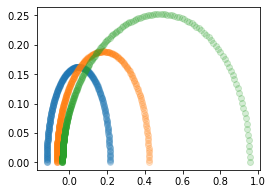

In [3]:
theta = np.arange(0, np.pi, 0.01)
g = np.arange(0.1, 0.51, 0.2)
p = np.zeros(shape=(len(g), len(theta)))
for i in range(len(g)):
    p[i,:] = (1-g[i]*g[i])/((1+g[i]*g[i]-2*g[i]*np.cos(theta))**(3/2))/(2*np.pi) # 2*pi*p(theta)
    
px = p*np.cos(theta)
py = p*np.sin(theta)
    
plt.figure(figsize=(4, 3))
for i in range(len(g)):
    plt.scatter(px[i,:], py[i,:], alpha=0.2)
plt.show()


Draw the curve of $2\pi p(\theta) sin(\theta)$.

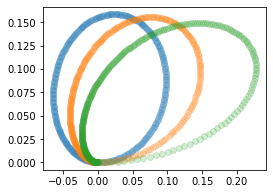

In [4]:
ps = p*np.sin(theta)
px = ps*np.cos(theta)
py = ps*np.sin(theta)
    
plt.figure(figsize=(4, 3))
for i in range(len(g)):
    plt.scatter(px[i,:], py[i,:], alpha=0.2)
plt.show()

## (2) Sample H-G distribution

In [45]:
def generate_HG_data(g, n_samples):
    x_data = np.random.uniform(0, 1, n_samples)
    y_data = (1+g**2 - ((1-g**2)/(1-g+2*g*x_data))**2)/(2*g)
    return x_data, y_data
    
g = 0.9
n_samples = 1000
x_data, y_data = generate_HG_data(g, n_samples)

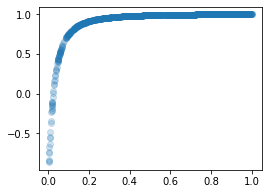

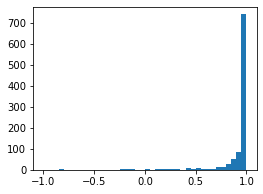

In [48]:
plt.figure(figsize=(4, 3))
plt.scatter(x_data, y_data, alpha=0.2)
plt.show()
plt.figure(figsize=(4, 3))
plt.hist(y_data,bins=np.arange(-1,1.01,0.05))
plt.show()

Since $\mu=\cos(\theta)$, we can also show the histogram of $\theta$.

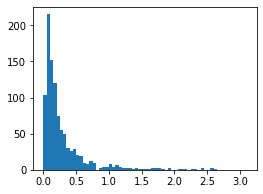

In [50]:
theta = np.arccos(y_data)
plt.figure(figsize=(4, 3))
plt.hist(theta,bins=np.arange(0,np.pi,0.05))
plt.show()

## (3) Learning H-G function with a MLP

We will use the sampled data to train a neural network with one hidden layer to act as the H-G function. Given a random number that follows the uniform distribution of $[0,1]$, the neural network will produce an output that follows an H-G distribution, with the parameter $g$ defined by the training data. 

This neural network is described by the following equation:

$y_{pred}(x) = w_{out} \tanh( w_{in} x + b_{in}) + b_{out}$

- $y_{pred}(x)$: this function $y_{pred}$ takes $x$ as input.
- $w_{in}, w_{out}$: weights for the input and output layers.
- $b_{in}, b_{out}$: biases for the input and output layers.
- $\tanh$: a nonlinear activation function.

Let's create this network using 20 hidden nodes.

In [65]:
n_input = 1
n_hidden = 20
n_output = 1

# create the network (also called a "model" of the data)
network = nn.Sequential(nn.Linear(n_input, n_hidden),
                        nn.Tanh(),
                        nn.Linear(n_hidden, n_output))

To train the network we must define a loss function. Also called a "cost function", this is a description of what counts as "better" or "worse" results, and allows us to modify the network to achieve the best results.

We will use the [mean squared error](https://en.wikipedia.org/wiki/Mean_squared_error) loss function.

In [66]:
loss_fn = nn.MSELoss()

We also need to pick an optimizer. Optimizers use the loss to determine which parameters in the network should be changed, and how much.

We will use the [RMSprop](http://ruder.io/optimizing-gradient-descent/index.html#rmsprop) optimizer, which happens to work well for this problem.

In [67]:
optimizer = torch.optim.RMSprop(network.parameters())

Now let's move our data from numpy to PyTorch. This requires:

1. Converting the data from `np.float64` (numpy default) to `np.float32` (Torch default).
2. Reshaping the data from `(n_samples)` to `(n_samples, n_input)`. Typically the first dimension is your batch size, but here we are processing all the samples in one batch.
3. Convert from a numpy array to a PyTorch tensor.
4. Initialize an input and output `Variable` that we can feed the x and y tensors.

We will use this naming convention:

- numpy arrays `x_data`
- PyTorch tensors `x_tensor`
- PyTorch Variables `x_variable`

In [68]:
# change data type and shape, move from numpy to torch
# note that we need to convert all data to np.float32 for pytorch
x_tensor = torch.from_numpy(np.float32(x_data).reshape(n_samples, n_input))
y_tensor = torch.from_numpy(np.float32(y_data).reshape(n_samples, n_input))
x_variable = Variable(x_tensor)
y_variable = Variable(y_tensor, requires_grad=False)

Now let's define a training loop. It will use the optimizer to minimize the loss function by modifying the network's parameters.

In [69]:
def train():
    for epoch in range(3001):
        y_pred = network(x_variable) # make a prediction
        loss = loss_fn(y_pred, y_variable) # compute the loss
        optimizer.zero_grad() # prepare the optimizer
        loss.backward() # compute the contribution of each parameter to the loss
        optimizer.step() # modify the parameters

        if epoch % 300 == 0:
            print(epoch, loss.data.item())

train()

0 2.1644339561462402
300 0.040815990418195724
600 0.01054393034428358
900 0.006842751521617174
1200 0.0033278814516961575
1500 0.0020158428233116865
1800 0.0013520836364477873
2100 0.001161294407211244
2400 0.00089091039262712
2700 0.0015932905953377485


Let's see how the neural network performs by processing some evenly spaced samples.

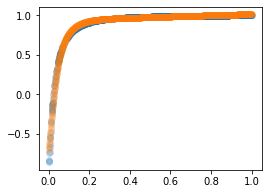

In [70]:
# evenly spaced samples from 0 to 1
x_test_data = np.linspace(0, 1, n_samples)

# change data shape, move from numpy to torch
x_test_tensor = torch.from_numpy(np.float32(x_test_data).reshape(n_samples, n_input))
x_test_variable = Variable(x_test_tensor)
y_test_variable = network(x_test_variable)

# move from torch back to numpy
y_test_data = y_test_variable.data.numpy()

# plot the original data and the test data
plt.figure(figsize=(4, 3))
plt.scatter(x_data, y_data, alpha=0.2)
plt.scatter(x_test_data, y_test_data, alpha=0.2)
plt.show()

The network fits the data generated by H-G function directly quite well, as expected. By this way, we say that the neural network is equivalent to a H_G function.

## Mixture Density Networks ##

Mixture Density Networks, developed by Christopher Bishop in the 1990s, are one way to produce multiple outputs from a single input. MDN predicts a *probability distribution* of possible output values. Then can sample several possible different output values for a given input.

This concept is quite powerful, and can be employed many current areas of machine learning research. It also allows us to calculate a sort of confidence factor in the predictions that the network is making.

The inverted sinusoid data we chose is not just a toy problem. In [the paper introducing MDNs](http://publications.aston.ac.uk/373/1/NCRG_94_004.pdf) an inverted sinusoid is used to describe the angle we need to move a robot arm to achieve a target location. MDNs are also used to model handwriting, where the next stroke is drawn from a probability distribution of multiple possibilities, rather than sticking to one prediction.

Bishop's implementation of MDNs will predict a class of probability distributions called Mixture of Gaussians or Gaussian Mixture Models, where the output value is modelled as a weighted sum of multiple Gaussians, each with different means and standard deviations.

So for each input $x$, we will predict a probability distribution function $P(y|x)$:

$P(y|x) = \sum_{k}^{K} \Pi_{k}(x) \phi(y, \mu_{k}(x), \sigma_{k}(x))$

- $k$ is an index describing which Gaussian we are referencing. There are $K$ Gaussians total.
- $\sum_{k}^{K}$ is the summation operator. We sum every $k$ Gaussian across all $K$. You might also see $\sum_{k=0}^{K-1}$ or $\sum_{k=1}^{K}$ depending on whether an author is using zero-based numbering or not.
- $\Pi_k$ acts as a weight, or multiplier, for mixing every $k$ Gaussian. It is a function of the input $x$: $\Pi_k(x)$
- $\phi$ is the Gaussian function and returns the at $y$ for a given mean and standard deviation.
- $\mu_k$ and $\sigma_k$ are the parameters for the $k$ Gaussian: mean $\mu_k$ and standard deviation $\sigma_k$. Instead of being fixed for each Gaussian, they are also functions of the input $x$: $\mu_k(x)$ and $\sigma_k(x)$

All of $\sigma_{k}$ are positive, and all of the weights $\Pi$ sum to one:

$\sum_{k}^{K} \Pi_{k} = 1$

First our network must learn the functions $\Pi_{k}(x), \mu_{k}(x), \sigma_{k}(x)$ for every $k$ Gaussian. Then these functions can be used to generate individual parameters $\mu_k, \sigma_k, \Pi_k$ for a given input $x$. These parameters will be used to generate our pdf $P(y|x)$. Finally, to make a prediction, we will need to sample (pick a value) from this pdf.

In our implementation, we will use a neural network of one hidden layer with 20 nodes. This will feed into another layer that generates the parameters for 5 mixtures: with 3 parameters $\Pi_k$, $\mu_k$, $\sigma_k$ for each Gaussian $k$.

Our definition will be split into three parts.

First we will compute 20 hidden values $z_h$ from our input $x$.

$z_h(x) = \tanh( W_{in} x + b_{in})$

Second, we will use these hidden values $z_h$ to compute our three sets of parameters $\Pi, \sigma, \mu$:

$
z_\Pi = W_{\Pi} z_h + b_{\Pi}\\
z_\sigma = W_{\sigma} z_h + b_{\sigma}\\
z_\mu = W_{\mu} z_h + b_{\mu}
$

Third, we will use the output of these layers to determine the parameters of the Gaussians.

$
\Pi = \frac{\exp(z_{\Pi})}{\sum_{k}^{K} \exp(z_{\Pi_k})}\\
\sigma = \exp(z_{\sigma})\\
\mu = z_{\mu}
$

- $\exp(x)$ is the exponential function also written as $e^x$

We use a [*softmax*](https://en.wikipedia.org/wiki/Softmax_function) operator to ensure that $\Pi$ sums to one across all $k$, and the exponential function ensures that each weight $\Pi_k$ is positive. We also use the exponential function to ensure that every $\sigma_k$ is positive.

Let's define our MDN network.

In [26]:
class MDN(nn.Module):
    def __init__(self, n_hidden, n_gaussians):
        super(MDN, self).__init__()
        self.z_h = nn.Sequential(
            nn.Linear(1, n_hidden),
            nn.Tanh()
        )
        self.z_pi = nn.Linear(n_hidden, n_gaussians)
        self.z_sigma = nn.Linear(n_hidden, n_gaussians)
        self.z_mu = nn.Linear(n_hidden, n_gaussians)  

    def forward(self, x):
        z_h = self.z_h(x)
        pi = nn.functional.softmax(self.z_pi(z_h), -1)
        sigma = torch.exp(self.z_sigma(z_h))
        mu = self.z_mu(z_h)
        return pi, sigma, mu

We cannot use the `MSELoss()` function for this task, because the output is an entire description of the probability distribution and not just a single value. A more suitable loss function is the logarithm of the likelihood of the output distribution vs the training data:

$loss(y | x) = -\log[ \sum_{k}^{K} \Pi_{k}(x) \phi(y, \mu_{k}(x), \sigma_{k}(x)) ]$

So for every $x$ input and $y$ output pair in the training data set, we can compute a loss based on the predicted distribution versus the actual distribution, and then attempt the minimise the sum of all the costs combined. To those who are familiar with logistic regression and cross entropy minimisation of softmax, this is a similar approach, but with non-discretised states.

We have to implement this cost function ourselves:

In [27]:
oneDivSqrtTwoPI = 1.0 / np.sqrt(2.0*np.pi) # normalization factor for Gaussians
def gaussian_distribution(y, mu, sigma):
    # make |mu|=K copies of y, subtract mu, divide by sigma
    result = (y.expand_as(mu) - mu) * torch.reciprocal(sigma)
    result = -0.5 * (result * result)
    return (torch.exp(result) * torch.reciprocal(sigma)) * oneDivSqrtTwoPI

def mdn_loss_fn(pi, sigma, mu, y):
    result = gaussian_distribution(y, mu, sigma) * pi
    result = torch.sum(result, dim=1)
    result = -torch.log(result)
    return torch.mean(result)

Let's create our MDN with 20 hidden nodes and 5 Gaussians.

In [28]:
network = MDN(n_hidden=20, n_gaussians=5)

We'll use a different optimizer this time called Adam that is more suited to this task.

In [29]:
optimizer = torch.optim.Adam(network.parameters())

We could generate more data to train the MDN, but what we have is nearly enough.

In [30]:
mdn_x_data = y_data
mdn_y_data = x_data

mdn_x_tensor = y_tensor
mdn_y_tensor = x_tensor

x_variable = Variable(mdn_x_tensor)
y_variable = Variable(mdn_y_tensor, requires_grad=False)

Finally, let's define a new training loop. We need a training loop that can handle the new loss function, and the MDN needs to train longer than the previous network.

In [32]:
def train_mdn():
    for epoch in range(10000):
        pi_variable, sigma_variable, mu_variable = network(x_variable)
        loss = mdn_loss_fn(pi_variable, sigma_variable, mu_variable, y_variable)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if epoch % 500 == 0:
            print(epoch, loss.data.item())

train_mdn()

0 7.234692573547363
500 3.0142135620117188
1000 2.836325168609619
1500 2.075873851776123
2000 1.9436392784118652
2500 1.8348963260650635
3000 1.7437915802001953
3500 1.7015432119369507
4000 1.6735928058624268
4500 1.645179271697998
5000 1.617496132850647
5500 1.3939237594604492
6000 1.319673776626587
6500 1.3009649515151978
7000 1.2903928756713867
7500 1.2821402549743652
8000 1.273856282234192
8500 1.2636067867279053
9000 1.2506811618804932
9500 1.240720272064209


Once the training is finished, we can observe all the parameters for the Gaussians and see how they vary with respect to the input $x$.

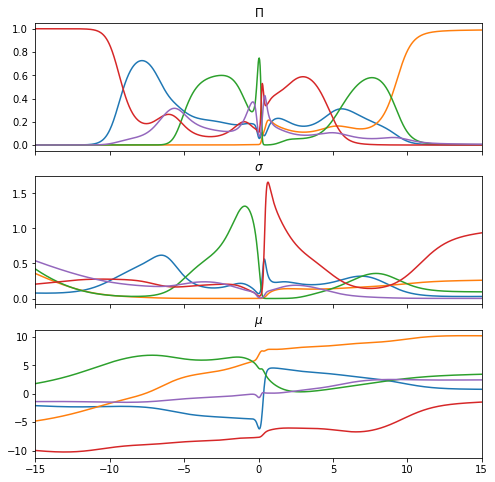

In [33]:
pi_variable, sigma_variable, mu_variable = network(x_test_variable)

pi_data = pi_variable.data.numpy()
sigma_data = sigma_variable.data.numpy()
mu_data = mu_variable.data.numpy()

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(8,8))
ax1.plot(x_test_data, pi_data)
ax1.set_title('$\Pi$')
ax2.plot(x_test_data, sigma_data)
ax2.set_title('$\sigma$')
ax3.plot(x_test_data, mu_data)
ax3.set_title('$\mu$')
plt.xlim([-15,15])
plt.show()

We can also plot the $\mu$ of each Gaussian with respect to $x$, and show the range of by highlighting a region between $\mu-\sigma$ and $\mu+\sigma$.

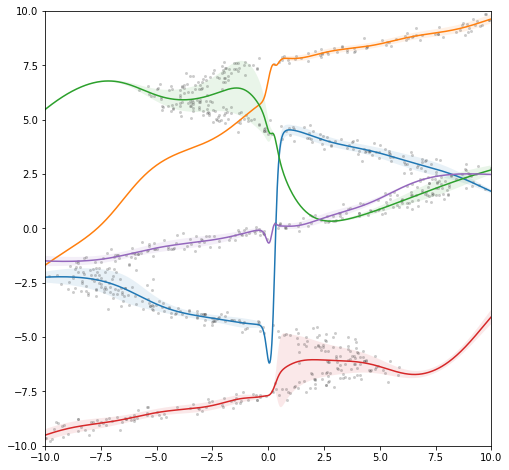

In [34]:
plt.figure(figsize=(8, 8), facecolor='white')
for mu_k, sigma_k in zip(mu_data.T, sigma_data.T):
    plt.plot(x_test_data, mu_k)
    plt.fill_between(x_test_data, mu_k-sigma_k, mu_k+sigma_k, alpha=0.1)
plt.scatter(mdn_x_data, mdn_y_data, marker='.', lw=0, alpha=0.2, c='black')
plt.xlim([-10,10])
plt.ylim([-10,10])
plt.show()

In the plot above, we see that for every point on the $x$-axis, there are multiple lines or states where $y$ may be, and we select these states with probabilities modelled by $\Pi$. Note that the network won't find an ideal solution every time. It's possible to get lower loss by using more Gaussians, but the results are harder to interpret.

If we want to sample from the network we will need to pick a Gaussian $k$ and pick a value (sample) from that Gaussian. Here we use a trick called [Gumbel softmax sampling](http://timvieira.github.io/blog/post/2014/07/31/gumbel-max-trick/) to pick our $k$. We treat the $\Pi$ weights as a discrete distribution of probabilities, and sample one $k$ for each row of `pi_data`.

In [35]:
def gumbel_sample(x, axis=1):
    z = np.random.gumbel(loc=0, scale=1, size=x.shape)
    return (np.log(x) + z).argmax(axis=axis)

k = gumbel_sample(pi_data)

Now that we have selected $k$ for each row, we can select $\sigma$ and $\mu$ as well. We will use `np.random.randn` to sample from each Gaussian, scaling it by $\sigma$ and offsetting it by $\mu$.

In [36]:
indices = (np.arange(n_samples), k)
rn = np.random.randn(n_samples)
sampled = rn * sigma_data[indices] + mu_data[indices]

With these sampled $y$ values, we can overlay them on the original distribution to see how accurately the network captures the shape.

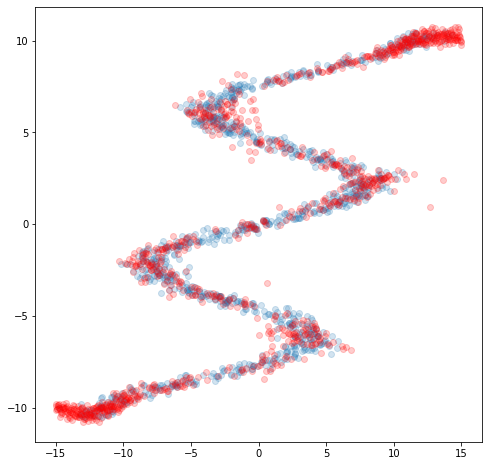

In [37]:
plt.figure(figsize=(8, 8))
plt.scatter(mdn_x_data, mdn_y_data, alpha=0.2)
plt.scatter(x_test_data, sampled, alpha=0.2, color='red')
plt.show()

Some other things to try:
    
- What other constraints might we enforce? Is it ever helpful to encourage $\Pi$ to be sparse to maintain a "simple" distribution?
- What kinds of regularization can we add to the network?
- Often very small sigma can create problems, it might be helpful to add `sigma += 0.01` inside the MDN.
- How do more or fewer Gaussians affect the result?
- How do more or fewer hidden nodes affect the result?
- What other kinds of nonlinear activation functions work besides `Tanh()`? Try `Sigmoid()` too.
- How do these plots move if you draw them in realtime while the network is training?
- What happens when if you use the [*softplus*](https://en.wikipedia.org/wiki/Softplus) function for making the $\sigma$ positive, instead of $\exp(x)$?